<center><h1>Khatri_Surbhi_HW4</h1></center>
<br>
<br>

Name: Surbhi Khatri
<br>
Github Username: surbhikhatri
<br>
USC ID: 9893833133

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download Data

Package imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bootstrapped

  Preparing metadata (setup.py) ... done
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13930 sha256=b6dc01327b1e0e7bebdea7171aa5d20572d9841d92ed397bd2ac99e2117e145f
  Stored in directory: /root/.cache/pip/wheels/63/89/c7/09fd0b2ce6a69f0b5884df971b0de884500fe20837a8a3ab7f
Successfully built bootstrapped


In [3]:
import pandas as pd
import os
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import warnings
from IPython.display import display, HTML
from tabulate import tabulate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import numpy as np
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from copy import deepcopy
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,cross_val_score

columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
warnings.filterwarnings("ignore")

Get the AReM Data Set

In [4]:
# same as assignment 3
dir = os.walk("./drive/MyDrive/AReM")
i = 0
types = []
test_df = pd.DataFrame()
train_df = pd.DataFrame()
csvnum = 1

for path, sub, file in dir:
    if i == 0:
        types = sub
    else:
        type = types[i-1]
        for name in file:
            data = pd.read_csv(os.path.join(path, name), on_bad_lines='skip', comment="#", header=None, sep='[\s,]')
            data["csvnum"] = csvnum
            data["class"] = type
            data["dataset"] = name

            # keep all - ds1, ds2, ds3 in train
            if name != "dataset1.csv" and name != "dataset2.csv" and name != "dataset3.csv" :
                train_df = pd.concat([train_df, data], ignore_index=True)
            # keep
            elif (type == "bending1" or type == "bending2") and name == "dataset3.csv":
                train_df = pd.concat([train_df,data], ignore_index=True)
            else:
                test_df = pd.concat([test_df,data], ignore_index=True)
            csvnum += 1
    i+=1

### (b) Test and Train Data

In [5]:
# same as assignment 3
train_df.columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23", "csvnum", "class","dataset"]
test_df.columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23", "csvnum", "class", "dataset"]
print(train_df.shape)
print(test_df.shape)

(33117, 10)
(9120, 10)


### (c) Feature Extraction

#### i. Research

Following are some time-domain features for time series:
• Minimum
• Maximum
• Mean
• Median
• Mode
• standard deviation
• Box plot stats: first Quartile, Third quartile
• Mean of absolute values
• Waveform Length
• Moving window
• Expanding window
• Slope Sign Chnage: Number of times slope changes the sign
• Zero corssing: number of times Zero value is crossed i.e. +ve to -ve and vice versa


#### ii. Extraction

In [6]:
# same as assignment 3
df_all = pd.concat([train_df, test_df], ignore_index=True)
feature_extraction_data = []
table_header = []
for i in range(1,7):
    str_i = str(i)
    table_header.extend(["Min" + str_i, "Max" + str_i, "Mean" + str_i, "Median" + str_i, "SD" + str_i, "Q1-" + str_i, "Q3-" + str_i])

y = []
# for all 88 features
for i in range (1, 89):
    features = []

    for col in columns[1:]:
        desc = df_all[df_all["csvnum"]==i][col].describe()
        features.append(desc["min"])
        features.append(desc["max"])
        features.append(desc["mean"])
        features.append(desc["50%"])
        features.append(desc["std"])
        features.append(desc["25%"])
        features.append(desc["75%"])

    feature_extraction_data.append(features)
    y.append(df_all[df_all["csvnum"]==i]["class"].iloc[0])

df_feature_ext = pd.DataFrame(feature_extraction_data, columns=table_header)
display(HTML(df_feature_ext.to_html()))
df_feature_ext["class"] = y
# print(df_feature_ext)

,Min1,Max1,Mean1,Median1,SD1,Q1-1,Q3-1,Min2,Max2,Mean2,Median2,SD2,Q1-2,Q3-2,Min3,Max3,Mean3,Median3,SD3,Q1-3,Q3-3,Min4,Max4,Mean4,Median4,SD4,Q1-4,Q3-4,Min5,Max5,Mean5,Median5,SD5,Q1-5,Q3-5,Min6,Max6,Mean6,Median6,SD6,Q1-6,Q3-6
0,18.50,44.25,35.752354,36.000,4.614802,33.0000,39.3300,0.0,12.60,3.328104,2.830,2.140576,1.7750,4.3300,5.00,27.00,16.055021,16.000,3.446146,13.7300,18.3300,0.0,9.46,2.871125,2.650,1.704820,1.5000,3.7800,4.00,24.33,16.001271,16.250,3.120057,14.0000,18.0625,0.00,9.39,3.069667,2.770,1.748326,1.7975,4.0600
1,27.00,44.33,36.541667,36.000,4.018922,33.2500,39.8125,0.0,10.43,2.847958,2.450,1.892397,1.3000,4.1500,6.00,27.67,16.156063,16.000,3.439020,14.0000,18.0500,0.0,9.63,3.055458,2.870,1.742389,1.7975,4.0300,7.67,24.50,17.062625,16.750,3.088141,15.0000,19.5000,0.00,9.18,3.225458,2.870,1.769758,1.8850,4.2625
2,27.00,45.00,36.819521,36.000,3.900459,33.7500,40.2500,0.0,10.47,2.600146,2.120,1.821404,1.3000,3.8700,5.67,25.00,15.302625,15.000,3.504933,12.7500,17.6700,0.0,10.61,2.937021,2.620,1.661464,1.7000,3.8700,8.67,24.67,17.296271,17.415,2.781030,15.5000,19.2700,0.00,8.99,2.887563,2.525,1.723094,1.5600,3.7700
3,27.75,44.67,37.142359,36.330,3.762442,34.0000,40.5000,0.0,10.76,2.422150,1.890,1.643498,1.2500,3.3850,0.00,24.75,14.997954,15.000,3.292956,13.0000,17.2500,0.0,9.00,2.851044,2.500,1.716696,1.5800,3.9000,0.00,23.00,16.766096,17.000,2.687173,15.0000,18.7500,0.00,8.75,2.825720,2.590,1.637312,1.5900,3.7400
4,26.25,44.25,36.957458,36.290,3.434863,34.5000,40.2500,0.0,8.64,2.420083,2.050,1.724901,1.2500,3.3500,7.00,26.50,15.313417,15.250,3.034030,13.2500,17.3300,0.0,8.06,2.784146,2.565,1.542972,1.5800,3.7700,2.00,22.25,15.989167,16.330,2.851673,14.0000,18.2500,0.00,8.34,2.934625,2.525,1.631380,1.6600,4.0300
5,26.75,44.75,36.863375,36.330,3.555787,34.5000,39.7500,0.0,11.68,2.757312,2.230,2.115958,1.2200,4.0225,7.00,27.00,16.494750,16.000,3.588183,14.0000,19.0000,0.0,9.01,3.013604,2.860,1.774531,1.5600,4.0675,8.00,23.00,16.581146,16.750,2.655906,15.0000,18.6700,0.00,8.81,2.773313,2.590,1.569919,1.6400,3.6325
6,25.33,45.00,37.114313,36.250,3.710385,34.5000,40.2500,0.0,10.84,2.730000,2.240,1.924366,1.3000,3.7175,3.00,27.25,16.663917,16.670,3.612221,14.2500,18.8125,0.0,10.57,3.138542,2.870,1.847680,1.7900,4.1100,6.75,23.33,16.487542,16.670,2.847876,14.7500,18.5000,0.00,9.50,3.076354,2.770,1.824534,1.7000,4.0375
7,26.50,44.33,36.687292,36.000,3.529404,34.2500,39.3725,0.0,12.89,2.973042,2.360,2.073903,1.4100,4.2625,8.33,28.25,18.396792,18.000,3.771098,15.6700,20.7500,0.0,9.63,2.976604,2.685,1.861730,1.4800,4.0900,3.00,24.67,16.480000,16.750,2.978238,14.6700,18.5000,0.00,8.19,3.073313,2.690,1.629675,1.9125,4.0875
8,19.00,44.00,36.228396,36.000,3.528617,34.0000,39.0000,0.0,12.28,2.831687,2.285,1.886689,1.5000,3.8450,5.50,25.25,15.424500,15.250,3.249834,13.3300,17.5000,0.0,9.50,3.119125,2.940,1.683513,1.7900,4.2175,2.50,24.50,15.872375,16.000,3.166655,14.0000,18.0625,0.00,9.98,3.480688,3.340,1.827769,2.1025,4.5500
9,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,1.920,1.996887,1.2500,3.3500,6.33,24.00,16.388313,16.500,3.537950,13.7500,19.0000,0.0,9.74,2.980688,2.860,1.612059,1.7900,4.0000,7.50,24.25,18.125958,18.875,3.537144,16.0000,21.0000,0.00,8.55,2.983750,2.570,1.815730,1.5000,4.1500


#### iii. Standard Deviation

In [7]:
# same as assignment 3
features_extracted = ["Min", "Max", "Mean", "Median", "SD", "Q1-", "Q3-"]

print("std deviation and 90% bootstrap confidence interval")
for f in features_extracted:
    for k in range(1,7):
        fea_array = df_feature_ext[f + str(k)].to_numpy()
        print(f + str(k), bs.bootstrap(fea_array, stat_func=bs_stats.std, alpha=.10))

std deviation and 90% bootstrap confidence interval
Min1 9.515445066931841    (8.34626812000307, 10.837147422150245)
Min2 0.0    (0.0, 0.0)
Min3 2.9396159844182215    (2.7880298189385466, 3.13735627035937)
Min4 0.0    (0.0, 0.0)
Min5 6.0891065514606755    (4.679337637003715, 7.755294795244971)
Min6 0.045576965827593074    (0.013124961748951322, 0.09115393165518615)
Max1 4.36932238296287    (3.4930820942067484, 5.431347401791853)
Max2 5.033881679163114    (4.693950108421223, 5.477219983999364)
Max3 4.8473579111726695    (4.2623993647652885, 5.543311818655931)
Max4 2.171183073234498    (1.9872674723235577, 2.3772402192233546)
Max5 5.7085244261061385    (4.8802765336382645, 6.701350048870006)
Max6 2.50456803477282    (2.2610267740904564, 2.772932065372046)
Mean1 5.305297059209726    (4.764178024985129, 5.92747113300936)
Mean2 1.565227734208665    (1.438114768862563, 1.7409979046126107)
Mean3 3.98538924415904    (3.5106245176893855, 4.574181206007322)
Mean4 1.1595325776254781    (1.1037043

iv. Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max)

Ans:
Mean, Standard deviation, quartiles (Q1 and Q3) are good feature extraction method Because:

Mean and standard deviation gives a good understanding to the central value and the spread of the data around the central value with is important for differentiation the data
Median is a good indicator of central value but mean is a better seperator and mean also works with standard deviation to understand the spread of the data around central value.
Both first and third quatile are good to seperator and provide similar information and separation to the data we have, third quatile is slightly better in this dataset, so I picked Q3 oer Q1
Min and Max are both affected by outliers in the data and hence they are not good extraction methods.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook)

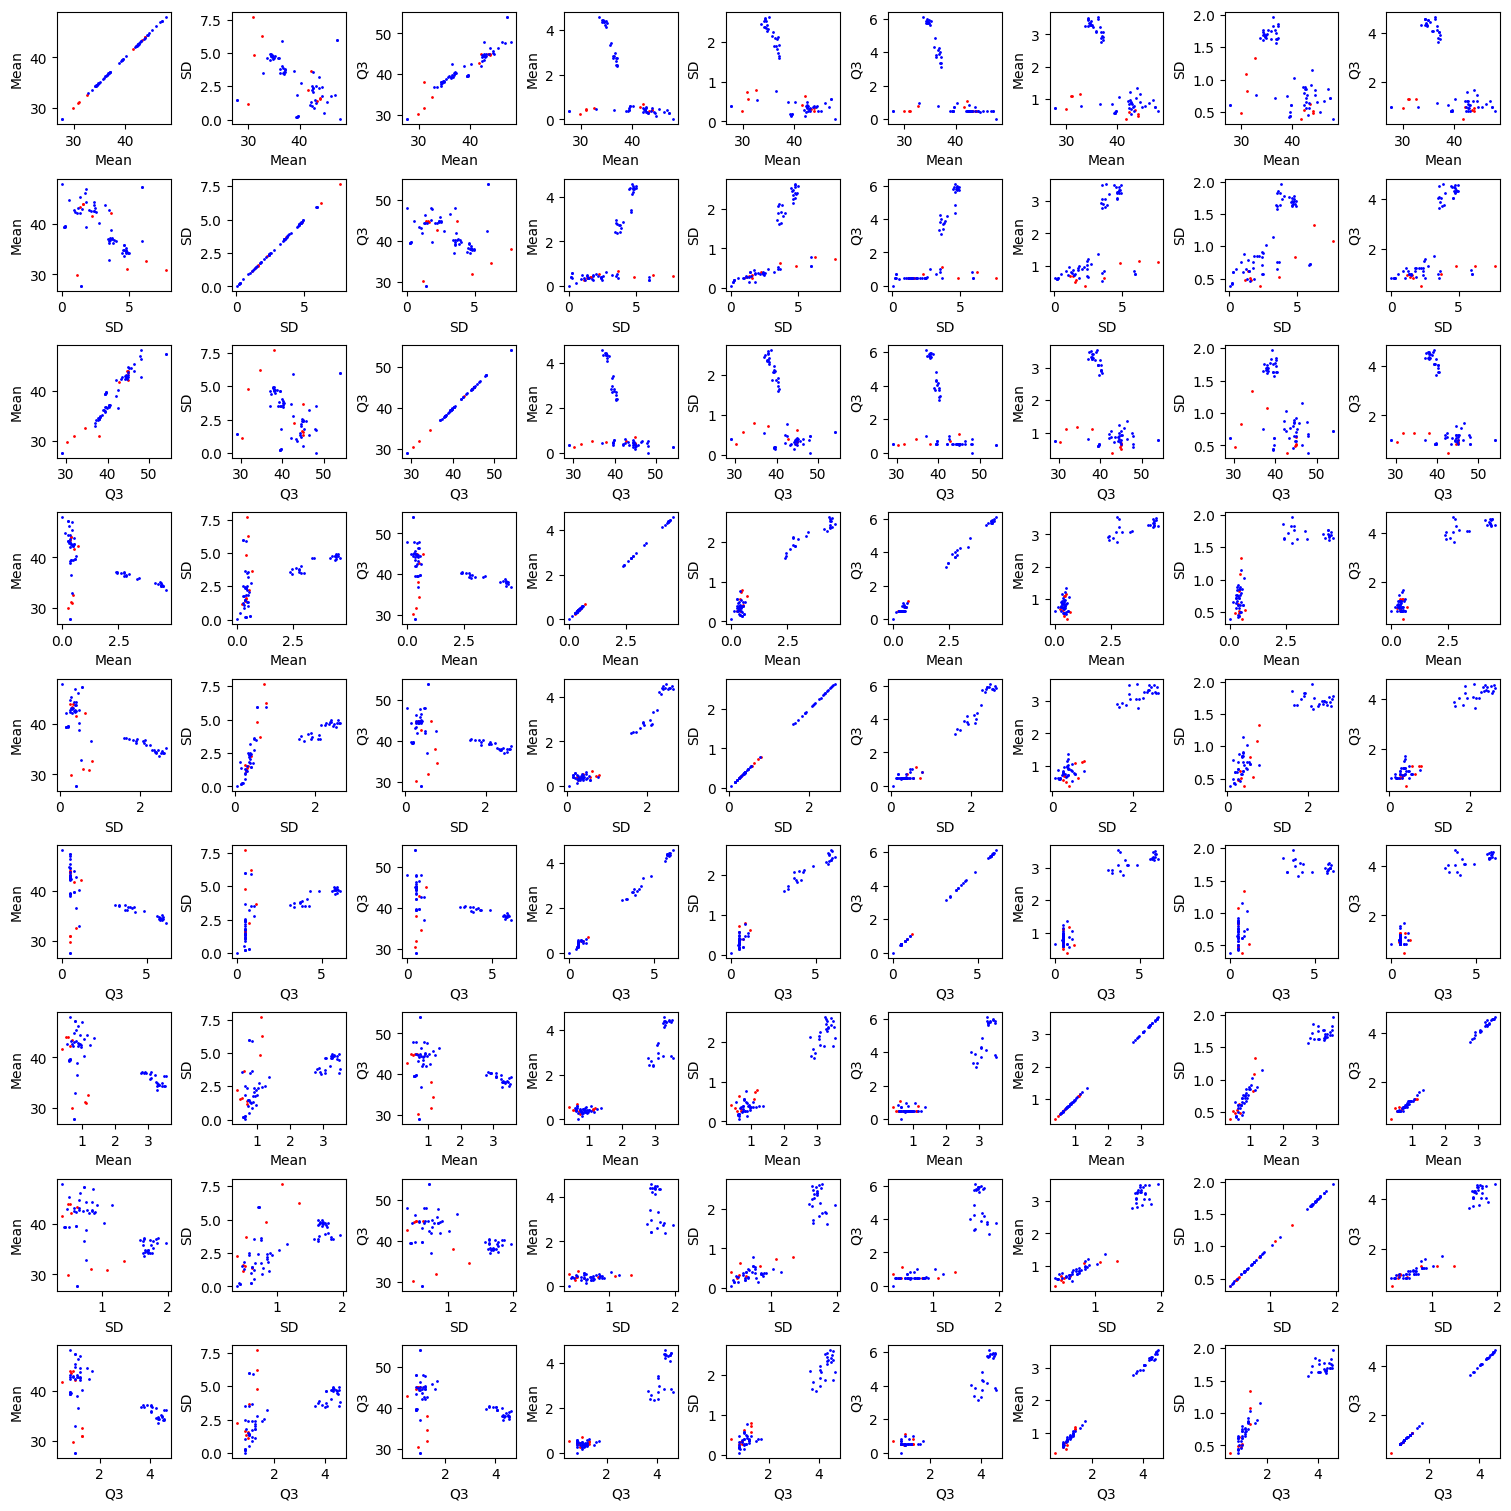

In [8]:
# This split argument will be used in later parts, will resue the same method
def extract_features(df, split):
    feature_data = []
    classes = []
    dataset = []
    # should be of len 88
    csvnum = df["csvnum"].unique()

    for i in csvnum:
        feature = []
        # use time series 1, 2, and 6
        for col in [columns[1], columns[2], columns[6]]:
            # 480 rows in each .csv file, get the step value to divide it
            step = 480//split
            for j in range (0, 480, step):
                desc = df[df["csvnum"]==i][col][j:j + step].describe()
                # features selected in previous question
                feature.append(desc["mean"])
                feature.append(desc["std"])
                feature.append(desc["75%"])
        feature_data.append(feature)
        classes.append(df[df["csvnum"]==i]["class"].iloc[0])
        dataset.append(df[df["csvnum"]==i]["dataset"].iloc[0])
    df_ext_fea = pd.DataFrame(feature_data)
    df_ext_fea["class"] = classes
    df_ext_fea["dataset"] = dataset
    return df_ext_fea

df_ext_fea = extract_features(train_df, 1)
df_subset = df_ext_fea
# divide in bending vs non-bending
df_bending = df_subset[(df_subset["class"] == "bending1") | (df_subset["class"] == "bending2")]
df_non_bending = df_subset[(df_subset["class"] != "bending1") & (df_subset["class"] != "bending2")]


features=["Mean", "SD", "Q3"]
fig, ax = plt.subplots(9, 9, constrained_layout=True, figsize=(15,15))

for i in range(9):
    for j in range(9):
        ax[i,j].scatter(df_bending[i], df_bending[j], color="r", s=1)
        ax[i,j].scatter(df_non_bending[i], df_non_bending[j], color="b", s=1)
        ax[i,j].set_xlabel(features[i%3])
        ax[i,j].set_ylabel(features[j%3])

plt.show()

#### ii. Splitted Plots
Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i

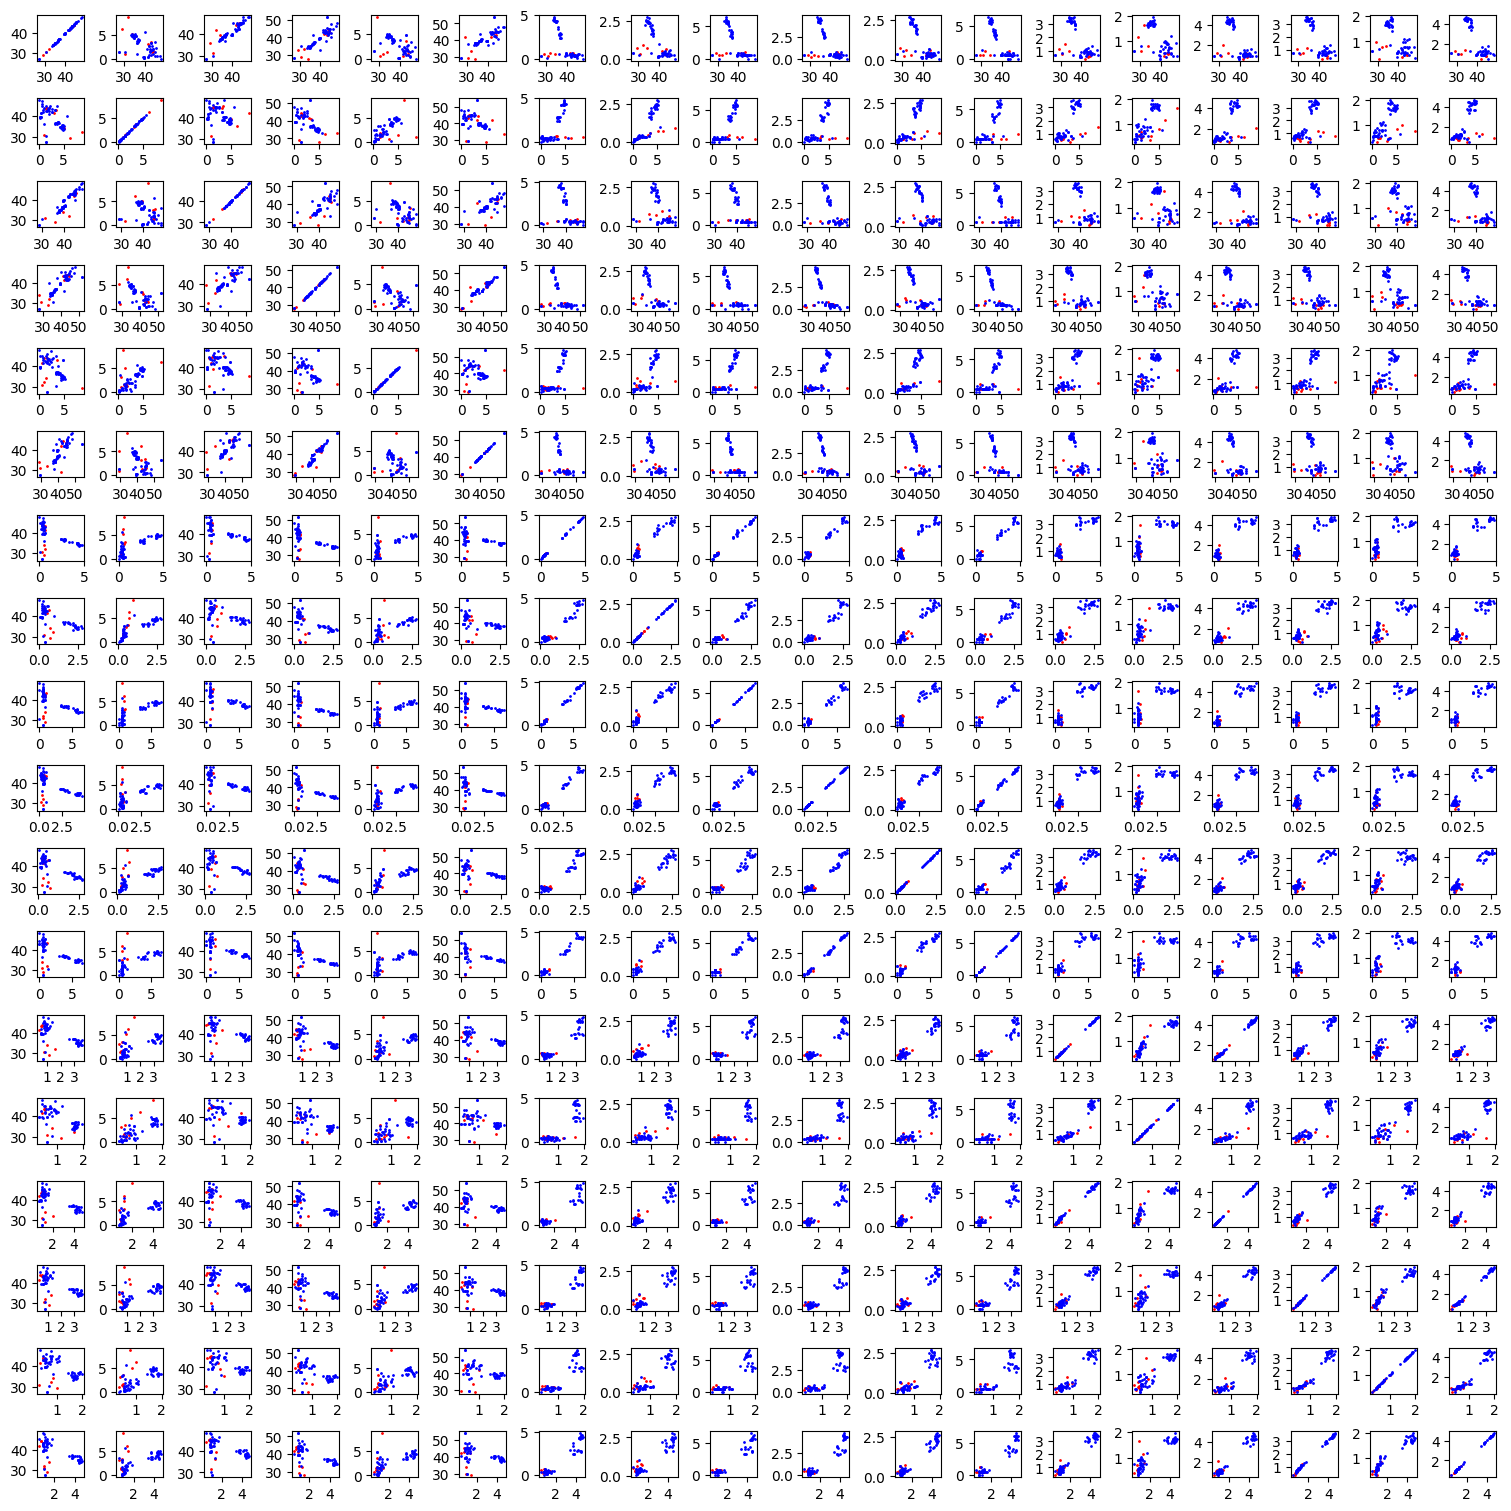

In [9]:
# split in 2 parts
df_ext_fea = extract_features(train_df, 2)
df_subset = df_ext_fea

# create new subsets bending vs non-bending
df_bending = df_subset[(df_subset["class"] == "bending1") | (df_subset["class"] == "bending2")]
df_non_bending = df_subset[(df_subset["class"] != "bending1") & (df_subset["class"] != "bending2")]

features = ["Mean", "SD", "Q3"]
fig, ax = plt.subplots(18, 18, constrained_layout=True, figsize=(15,15))
for i in range(18):
    for j in range(18):
        ax[i,j].scatter(df_bending[i], df_bending[j], color="r", s=1)
        ax[i,j].scatter(df_non_bending[i], df_non_bending[j], color="b", s=1)
plt.show()

#### iii. Time Series Segments
iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
of approximately equal length and use logistic regression5 to solve the binary
classification problem, using time-domain features. Remember that breaking
each of the time series does not change the number of instances. It only
changes the number of features for each instance. Calculate the p-values for
your logistic regression parameters in each model corresponding to each value
of l and refit a logistic regression model using your pruned set of features.6
Alternatively, you can use backward selection using sklearn.feature selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(l, p), where p is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use stratified cross
validation. Research what it means and use it if needed.
In the following, you can see an example of applying Python’s Recursive
Feature Elimination, which is a backward selection algorithm, to logistic re-
gression.
* Recursive Feature Elimination

from s k l e a r n import d a t a s e t s

from s k l e a r n . f e a t u r e s e l e c t i o n import RFE

from s k l e a r n . l i n e a r m o d e l import L o g i s t i c R e g r e s s i o n
* l o a d t he i r i s d a t a s e t s

dataset = datasets . l o a d i r i s ()
* c r e a t e a base c l a s s i f i e r used t o e v a l u a t e a s u b s e t o f a t t r i b u t e s

model = L o g i s t i c R e g r e s s i o n ( )
* c r e a t e th e RFE model and s e l e c t 3 a t t r i b u t e s

r f e = RFE( model , 3 )

r f e = r f e . f i t ( d a t a s e t . data , d a t a s e t . t a r g e t )
* summarize t he s e l e c t i o n o f t h e a t t r i b u t e s

print ( r f e . support )

print ( r f e . ranking )

In [10]:
# similar function with added features
def extract_more_features(df, split):
    feature_extraction_data = []
    classes = []
    dataset = []
    csvnum = df["csvnum"].unique()
    for i in csvnum:
        feature = []
        for col in columns[1:]:
            step = 480//split
            for j in range (0, 480, step):
                desc = df[df["csvnum"]==i][col][j:j+step].describe()
                feature.append(desc["min"])
                feature.append(desc["max"])
                feature.append(desc["mean"])
                feature.append(desc["50%"])
                feature.append(desc["std"])
                feature.append(desc["25%"])
                feature.append(desc["75%"])

        feature_extraction_data.append(feature)
        classes.append(df[df["csvnum"]==i]["class"].iloc[0])
        dataset.append(df[df["csvnum"]==i]["dataset"].iloc[0])
    df_ext_fea = pd.DataFrame(feature_extraction_data)
    df_ext_fea["class"] = classes
    df_ext_fea["dataset"] = dataset
    return df_ext_fea

In [11]:
feature_extracted_l_20 = []
for i in range(1,21):
    feature_extracted_l_20.append(extract_more_features(train_df, i))

In [12]:
# create y array for bending vs non-bending
def create_y(array):
    y = []
    for item in array:
        if item == "bending1" or item == "bending2":
            y.append(0)
        else:
            y.append(1)
    return y

In [13]:
# declare classes
classes = ["bending1", "bending2", "cycling", "lying"," sitting", "standing", "walking"]

# calculate p values
rel_features_index = []
l = 0
p = 0
best_model = None
i = 0
# print(len(feature_extracted_l_20))
for features in feature_extracted_l_20:
    i = i + 1
    x = features.drop(["class", "dataset"], axis=1)
    y = create_y(features["class"])
    model = LogisticRegression(penalty='none')
    # Recursive feature elimination with cross-validation to select features, using 5 fold
    rfecv = RFECV(model, cv=5)
    # refit a logistic regression
    res = rfecv.fit(x, y)
    score = rfecv.cv_results_["mean_test_score"][rfecv.n_features_-1]
    if score == 1:
        rel_features_index = [i for i, x in enumerate(res.support_) if x]
        # find best model, l, and p
        best_model = rfecv
        l = i
        p = rfecv.n_features_

print("best (l, p): (", l, " , " , p, ")")


best (l, p) are ( 20  ,  17 )


The wrong way to do cross validation is to do cross validation on only l and then for the best l doing cross validation for p.
we should do cross validation for all l times p and picks the best pair of l and p.

#### iv. Confusion Matrix
Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression
β
i
’s as well
as the p-values associated with them

[[ 9  0]
 [ 0 60]]


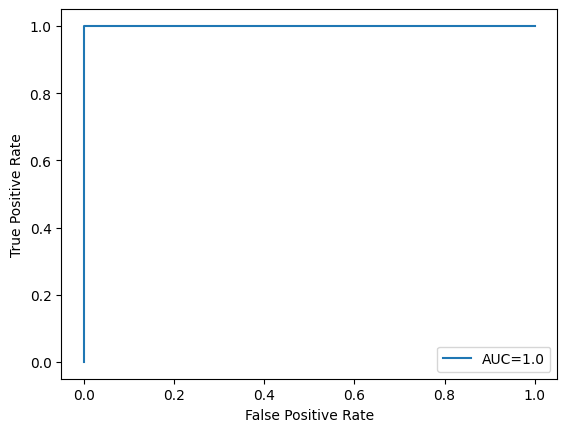

In [14]:
from sklearn import metrics

train_features_extracted = feature_extracted_l_20[l-1]
test_features_extracted = extract_features(test_df, l)

x_train = features.drop(["class", "dataset"], axis=1)
y_train = create_y(features["class"])
x_test = features.drop(["class", "dataset"], axis=1)
y_test = create_y(features["class"])

x_relavent_train = pd.DataFrame()
x_relavent_test = pd.DataFrame()
j = 0
for index in rel_features_index:
    x_relavent_train[j] = x_train[index]
    x_relavent_test[j] = x_test[index]
    j += 1

sklearn_model = LogisticRegression(penalty='none')
sklearn_model.fit(x_relavent_train, y_train)
y_train_pred = sklearn_model.predict(x_relavent_train)

print(metrics.confusion_matrix(y_train, y_train_pred))
# Receiver Operating Characteristic (ROC) curve is a graphical representation of
# a binary classification model's performance across different threshold values.
# It's a useful tool for evaluating the trade-off between the true positive rate
# (sensitivity) and the false positive rate (1-specificity) of a classification model.
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_pred)
auc = metrics.roc_auc_score(y_train, y_train_pred)

plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [15]:
model_ = sm.Logit(y_train, sm.add_constant(x_relavent_train))
result = model_.fit(maxiter=20)
# eport the parameters of your logistic regression βi’s as well as the p-values associated with them
print(result.summary())

         Current function value: 0.000040
         Iterations: 20
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                           17
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.9999
Time:                        21:59:21   Log-Likelihood:             -0.0027927
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.221e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1194    8.2e+04    9.9e-05      1.000   -1.61e+05    1.61e+05
0              0.8176   1667.811      0.000      1.000   -3268.03

#### v. Test Classifier
Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously

Testing score 1.0
[[ 9  0]
 [ 0 60]]


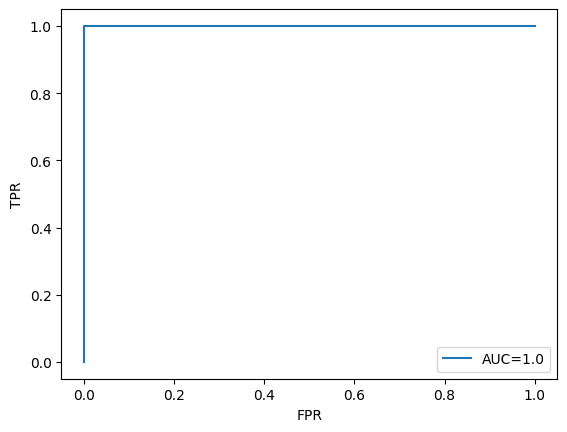

In [16]:
print("Testing score", sklearn_model.score(x_relavent_test, y_test))
y_test_pred = sklearn_model.predict(x_relavent_test)
print(metrics.confusion_matrix(y_test, y_test_pred))


fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred)
auc = metrics.roc_auc_score(y_test, y_test_pred)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.show()

#### vi. Separation
Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

Yes, there is a proper boundary between the two classes. This implies that, when the data is linearly seperable the loss function becomes more and more negative. Making the iterative algorithm to find beta'i never stop. We need to change the max iteration parameter to forcebly stop it. In this case, the classifier found actually works but the p-values are not reliable.

#### vii. Imbalance
From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

Yes, classes have imbalance.

previous beta0 8.119418953179173
New beta0 after case control sampling old beta0 4.085620730620576e-14
[[ 9.  0.]
 [ 1. 59.]]


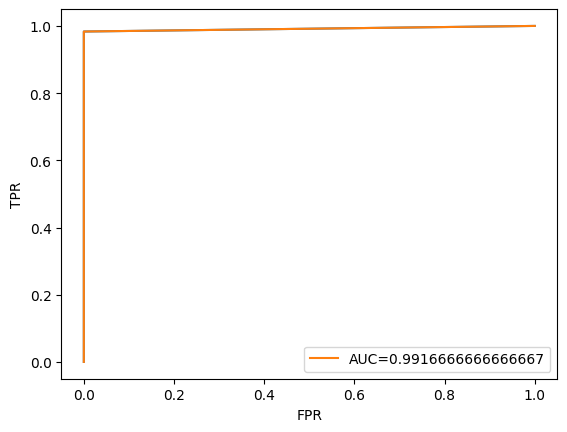

In [17]:
import math

B0 = res.params["const"]
print("previous beta0", B0)
pi_star = math.exp(B0)/(1+math.exp(B0))
# assuming
pi = .5
B0_new =  math.log(pi/(1-pi)) - math.log(pi_star/(1 - pi_star)) + B0
print("New beta0 after case control sampling old beta0", B0_new)

res.params["const"] = B0_new
pred = np.array(res.predict(sm.add_constant(x_relavent_test)) > .5, dtype=int)
# create ditribution table
table = np.histogram2d(y_test, pred, bins=2)[0]
print(table)

fpr, tpr, _ = metrics.roc_curve(y_train,  pred)
auc = metrics.roc_auc_score(y_train, pred)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, label="AUC=" + str(auc))

plt.ylabel('TPR')
plt.xlabel('FPR')

plt.legend(loc=4)
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments
Repeat 2(a)iii using
L
1
-penalized logistic regression,
8
i.e. instead of using p-
values for variable selection, use
L
1
regularization. Note that in this problem,
you have to cross-validate for both
l
, the number of time series into which you
break each of your instances, and
λ
, the weight of
L
1
penalty in your logistic
regression objective function (or
C
, the budget). Packages usually perform
cross-validation for
λ
automatically.
9

In [18]:
from sklearn import preprocessing
# find new c, l based on l and lambda
c = 0
l = 0
i = 0
normalizer = preprocessing.MinMaxScaler()
for features in feature_extracted_l_20:
    i += 1
    x = normalizer.fit_transform(features.drop(["class", "dataset"], axis=1))
    # resue same function
    y = create_y(features["class"])
    # use L1 penalty to fit the model
    model = LogisticRegressionCV(penalty='l1', solver="liblinear", cv=5)
    model.fit(x, y)
    score = model.score(x,y)
    # choose best c and l
    if score == 1:
        l = i
        c = model.C_
print("Best c and l for l1 is (", c, ",", l,")")

Best c and l for l1 regularisation is ( [2.7825594] , 20 )


#### ii. Comparison
Compare the
L
1
-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?


*   performs better: L1 penalized performs with better accuracy

*   easier to implement: L1 penalized is easier

*   time to run: L1 penalized takes much lesser time than varuable selection method





### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments
i.
Find the best
l
in the same way as you found it in 2(b)i to build an L1
penalized multinomial regression model to classify all activities in your train-
ing set.
10
Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possible.
1

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# similar to previous question but with division of 20
c = 0
l = 0
i = 0
normalizer = preprocessing.MinMaxScaler()
best_model = None
for features in feature_extracted_l_20:
    i += 1
    x = normalizer.fit_transform(features.drop(["class", "dataset"], axis=1))
    y = features["class"]
    # L1 penalty with multinomial class
    model = LogisticRegressionCV(penalty='l1', multi_class='multinomial', solver="saga")
    model.fit(x,y)
    score = model.score(x,y)
    # choose best c and l
    if score == 1:
        l = i
        c = model.C_
        best_model = model

print("Best c and l for l1: (", c, ",", l,")")


Best c and l for l1 regularisation is ( [166.81005372 166.81005372 166.81005372 166.81005372 166.81005372
 166.81005372 166.81005372] , 20 )


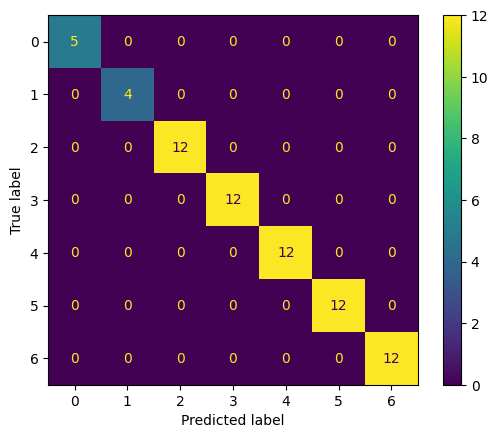

In [20]:
x = normalizer.fit_transform(feature_extracted_l_20[l-1].drop(["class", "dataset"], axis=1))
y = feature_extracted_l_20[l-1]["class"]
y_pred = best_model.predict(x)
confusion_mat = metrics.confusion_matrix(y,y_pred)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()



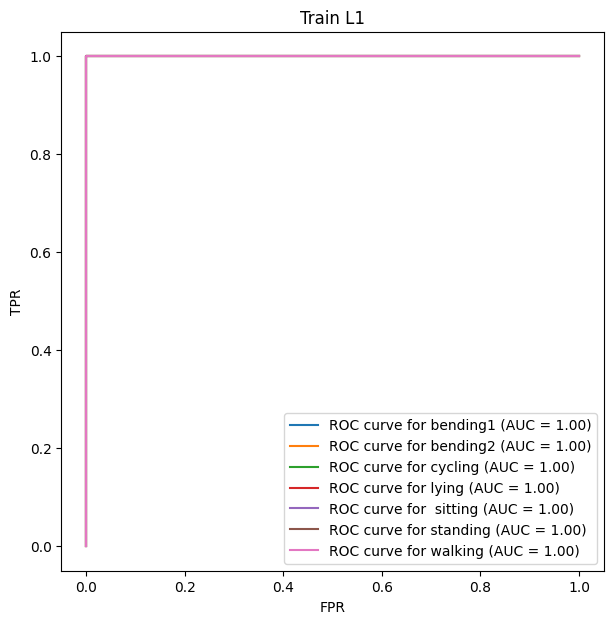

In [21]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y)
y_binary_test = label_binarizer.transform(y)

fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = best_model.predict_proba(x)
y_binary = pd.get_dummies(y)
fig, ax = plt.subplots(figsize=(7, 7))
for class_id, color in zip(range(7), classes):
    metrics.RocCurveDisplay.from_predictions(
        y_binary_test[:, class_id],
        y_score[:, class_id],
        name = f"ROC curve for {classes[class_id]}",
        ax = ax,
    )


plt.title("Train L1")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

Test L1 Muticlass: 0.8947368421052632


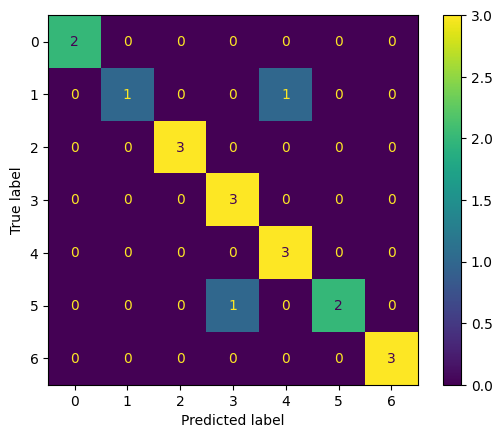

In [22]:
test_features_extract = extract_more_features(test_df, l)

x_test = normalizer.fit_transform(test_features_extract.drop(["class", "dataset"], axis=1))
y_test = test_features_extract["class"]
y_test_pred = best_model.predict(x_test)

print("Test L1 Muticlass:", best_model.score(x_test, y_test))
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()

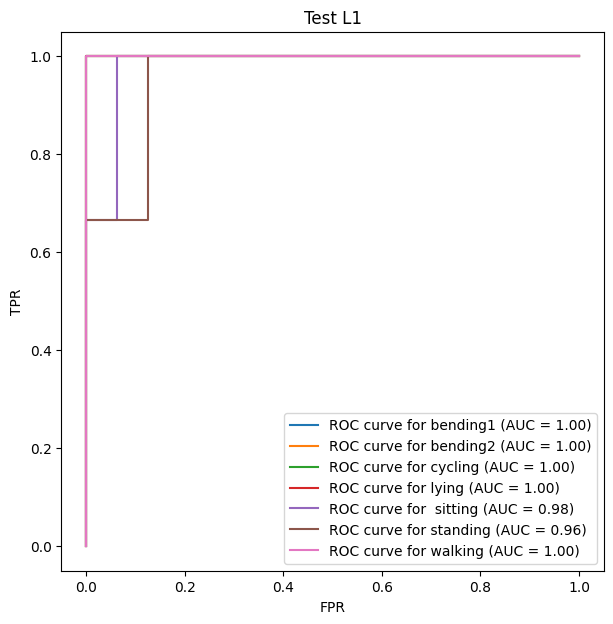

In [23]:
label_binarizer = LabelBinarizer().fit(y_test)
y_binary_test = label_binarizer.transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = best_model.predict_proba(x_test)
y_binary = pd.get_dummies(y_test)

fig, ax = plt.subplots(figsize=(7, 7))
for class_id, color in zip(range(7), classes):
    metrics.RocCurveDisplay.from_predictions(
        y_binary_test[:, class_id],
        y_score[:, class_id],
        name = f"ROC curve for {classes[class_id]}",
        ax = ax
    )

plt.title("Test L1")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


#### ii. Naive Bayes
Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi-
nomial priors and compare the results.

In [24]:
best_score = 0
best_model = None
i = 0

for fea in feature_extracted_l_20:
    i += 1
    fea = extract_more_features(train_df, i)
    x = fea.drop(["class", "dataset"], axis=1)
    y = fea["class"]
    model  = GaussianNB()
    score = np.mean(cross_val_score(model, x, y, cv=5, scoring="accuracy"))

    if best_score < score:
        best_score = score
        l = i

print("Best l: ", l)

Best l:  1


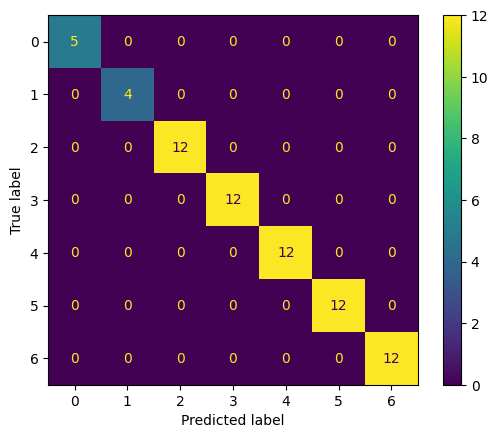

In [25]:
x = feature_extracted_l_20[l-1].drop(["class", "dataset"], axis=1)
y = feature_extracted_l_20[l-1]["class"]
gaussian_model = GaussianNB()
gaussian_model.fit(x,y)
y_pred_gaussian = gaussian_model.predict(x)


confusion_mat = metrics.confusion_matrix(y, y_pred_gaussian)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()

Test Error Gaussian: 0.8947368421052632


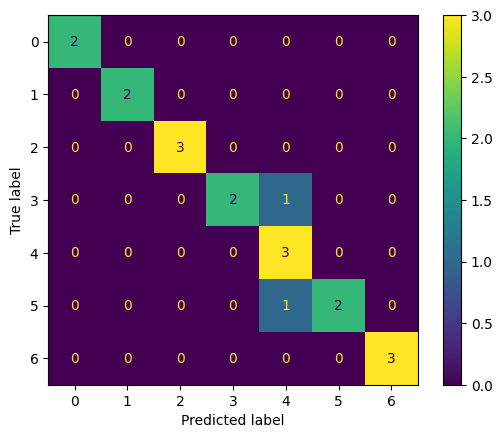

In [26]:
# same calculations on test: error and confussion matrix
test_features_extract = extract_more_features(test_df, l)

x_test = test_features_extract.drop(["class", "dataset"], axis=1)
y_test = test_features_extract["class"]
y_test_pred = gaussian_model.predict(x_test)

print("Test Error Gaussian:", gaussian_model.score(x_test, y_test))

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()

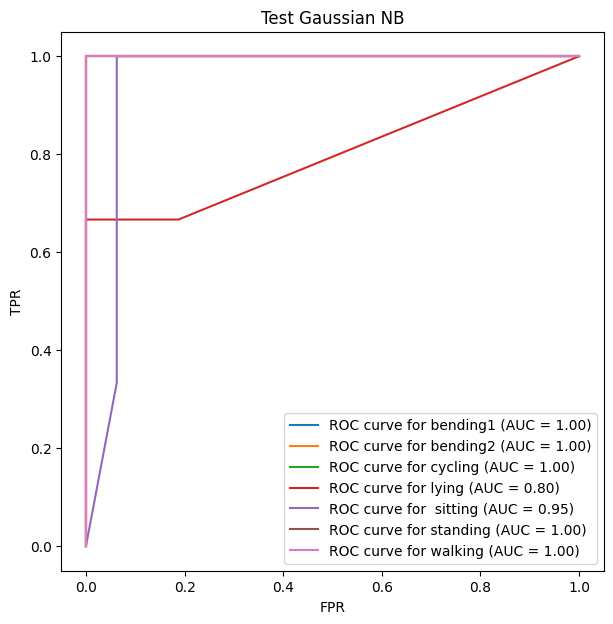

In [27]:
# Gaussian model FPR, TPR
label_binarizer = LabelBinarizer().fit(y_test)
y_binary_test = label_binarizer.transform(y_test)
y_score = gaussian_model.predict_proba(x_test)

fig, ax = plt.subplots(figsize=(7, 7))
for id, color in zip(range(7), classes):
    metrics.RocCurveDisplay.from_predictions(
        y_binary_test[:, id],
        y_score[:, id],
        name = f"ROC curve for {classes[id]}",
        ax = ax
    )
plt.title("Test Gaussian NB")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

Multinomial Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
# Best l for multinomial naive bayes

best_score = 0
i = 0
for fea in feature_extracted_l_20:
    i += 1
    fea = extract_more_features(train_df, i)
    x = fea.drop(["class", "dataset"],axis=1)
    y = fea["class"]
    # sklearn's multinomial naive bayes
    multi_model = MultinomialNB()
    score = np.mean(cross_val_score(multi_model, x, y, cv=5, scoring="accuracy"))

    if best_score < score:
        best_score = score
        l = i

print("Best l: ", l)

Best l:  1


Test Error L1 muticlass:  0.8947368421052632


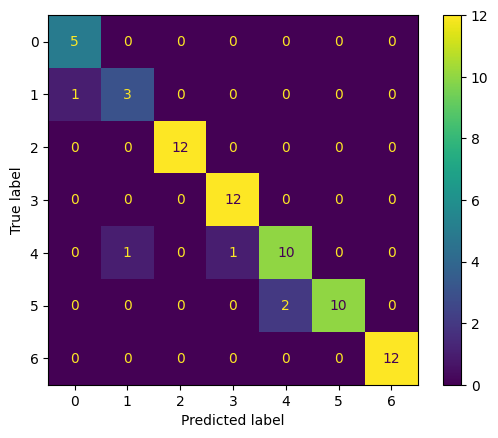

In [29]:
# for divided dataset + multiclass
x = feature_extracted_l_20[l-1].drop(["class", "dataset"], axis=1)
y = feature_extracted_l_20[l-1]["class"]

multi_model = MultinomialNB()
multi_model.fit(x,y)
y_pred_multi = multi_model.predict(x)

print("Test Error L1 muticlass: ", multi_model.score(x_test, y_test))

confusion_mat = metrics.confusion_matrix(y, y_pred_multi)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()

Test Score - multinomial Naive Bayes: 0.8947368421052632


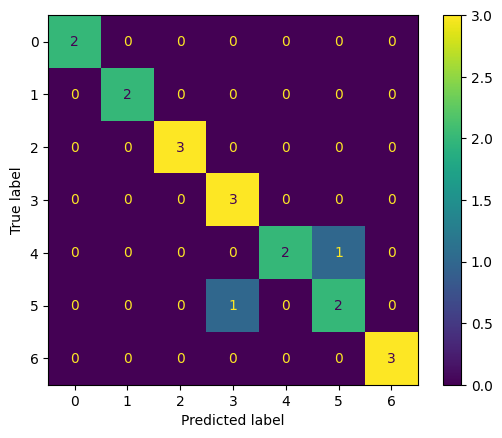

In [30]:
# same as 2c for multinomial NB
test_features_extract = extract_more_features(test_df, l)

x_test = test_features_extract.drop(["class", "dataset"], axis=1)
y_test = test_features_extract["class"]
y_test_pred = multi_model.predict(x_test)

print("Test Score - multinomial Naive Bayes:", multi_model.score(x_test, y_test))

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
confusion_mat_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
confusion_mat_display.plot()

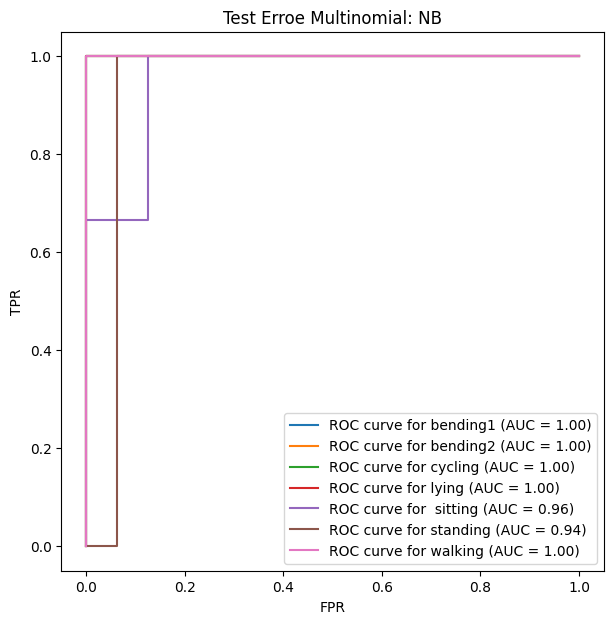

In [31]:
label_binarizer = LabelBinarizer().fit(y_test)
y_binary_test = label_binarizer.transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = multi_model.predict_proba(x_test)

fig, ax = plt.subplots(figsize=(7, 7))
for class_id, color in zip(range(7), classes):
    metrics.RocCurveDisplay.from_predictions(
        y_binary_test[:, class_id],
        y_score[:, class_id],
        name = f"ROC curve for {classes[class_id]}",
        ax = ax,
    )

plt.title("Test Erroe Multinomial: NB")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

#### iii. Comparison
Which method is better for multi-class classification in this problem?

Answer: L1-penalized multinomial regression performs the best on the test dataframe.




## 3. ISLR 4.8.3

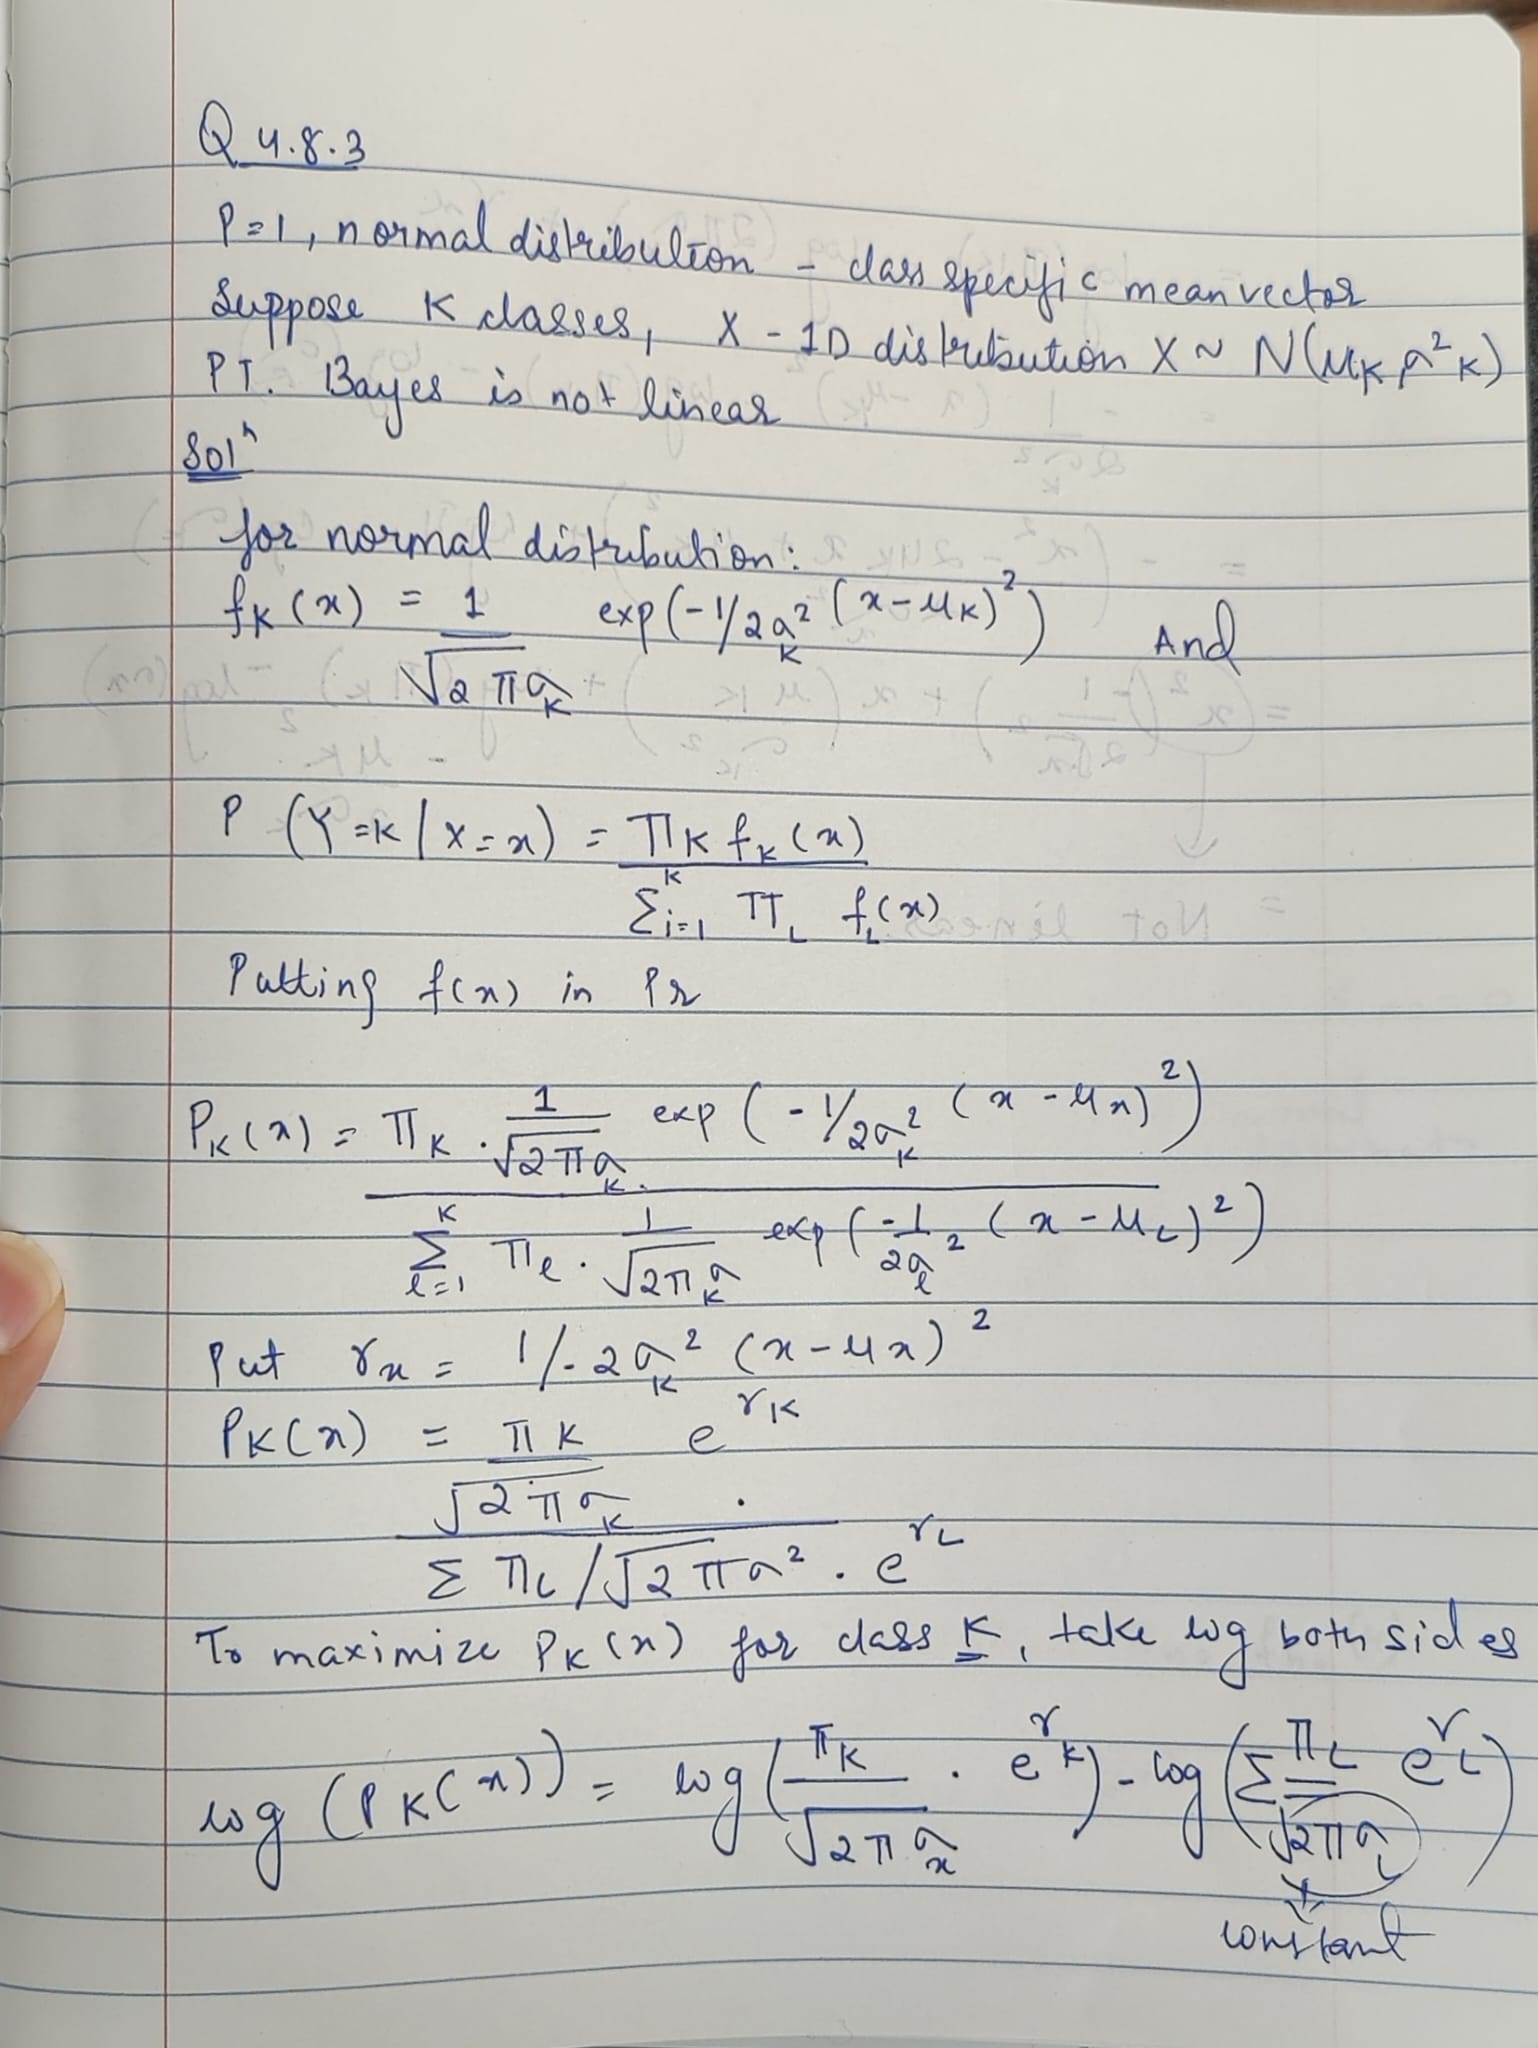


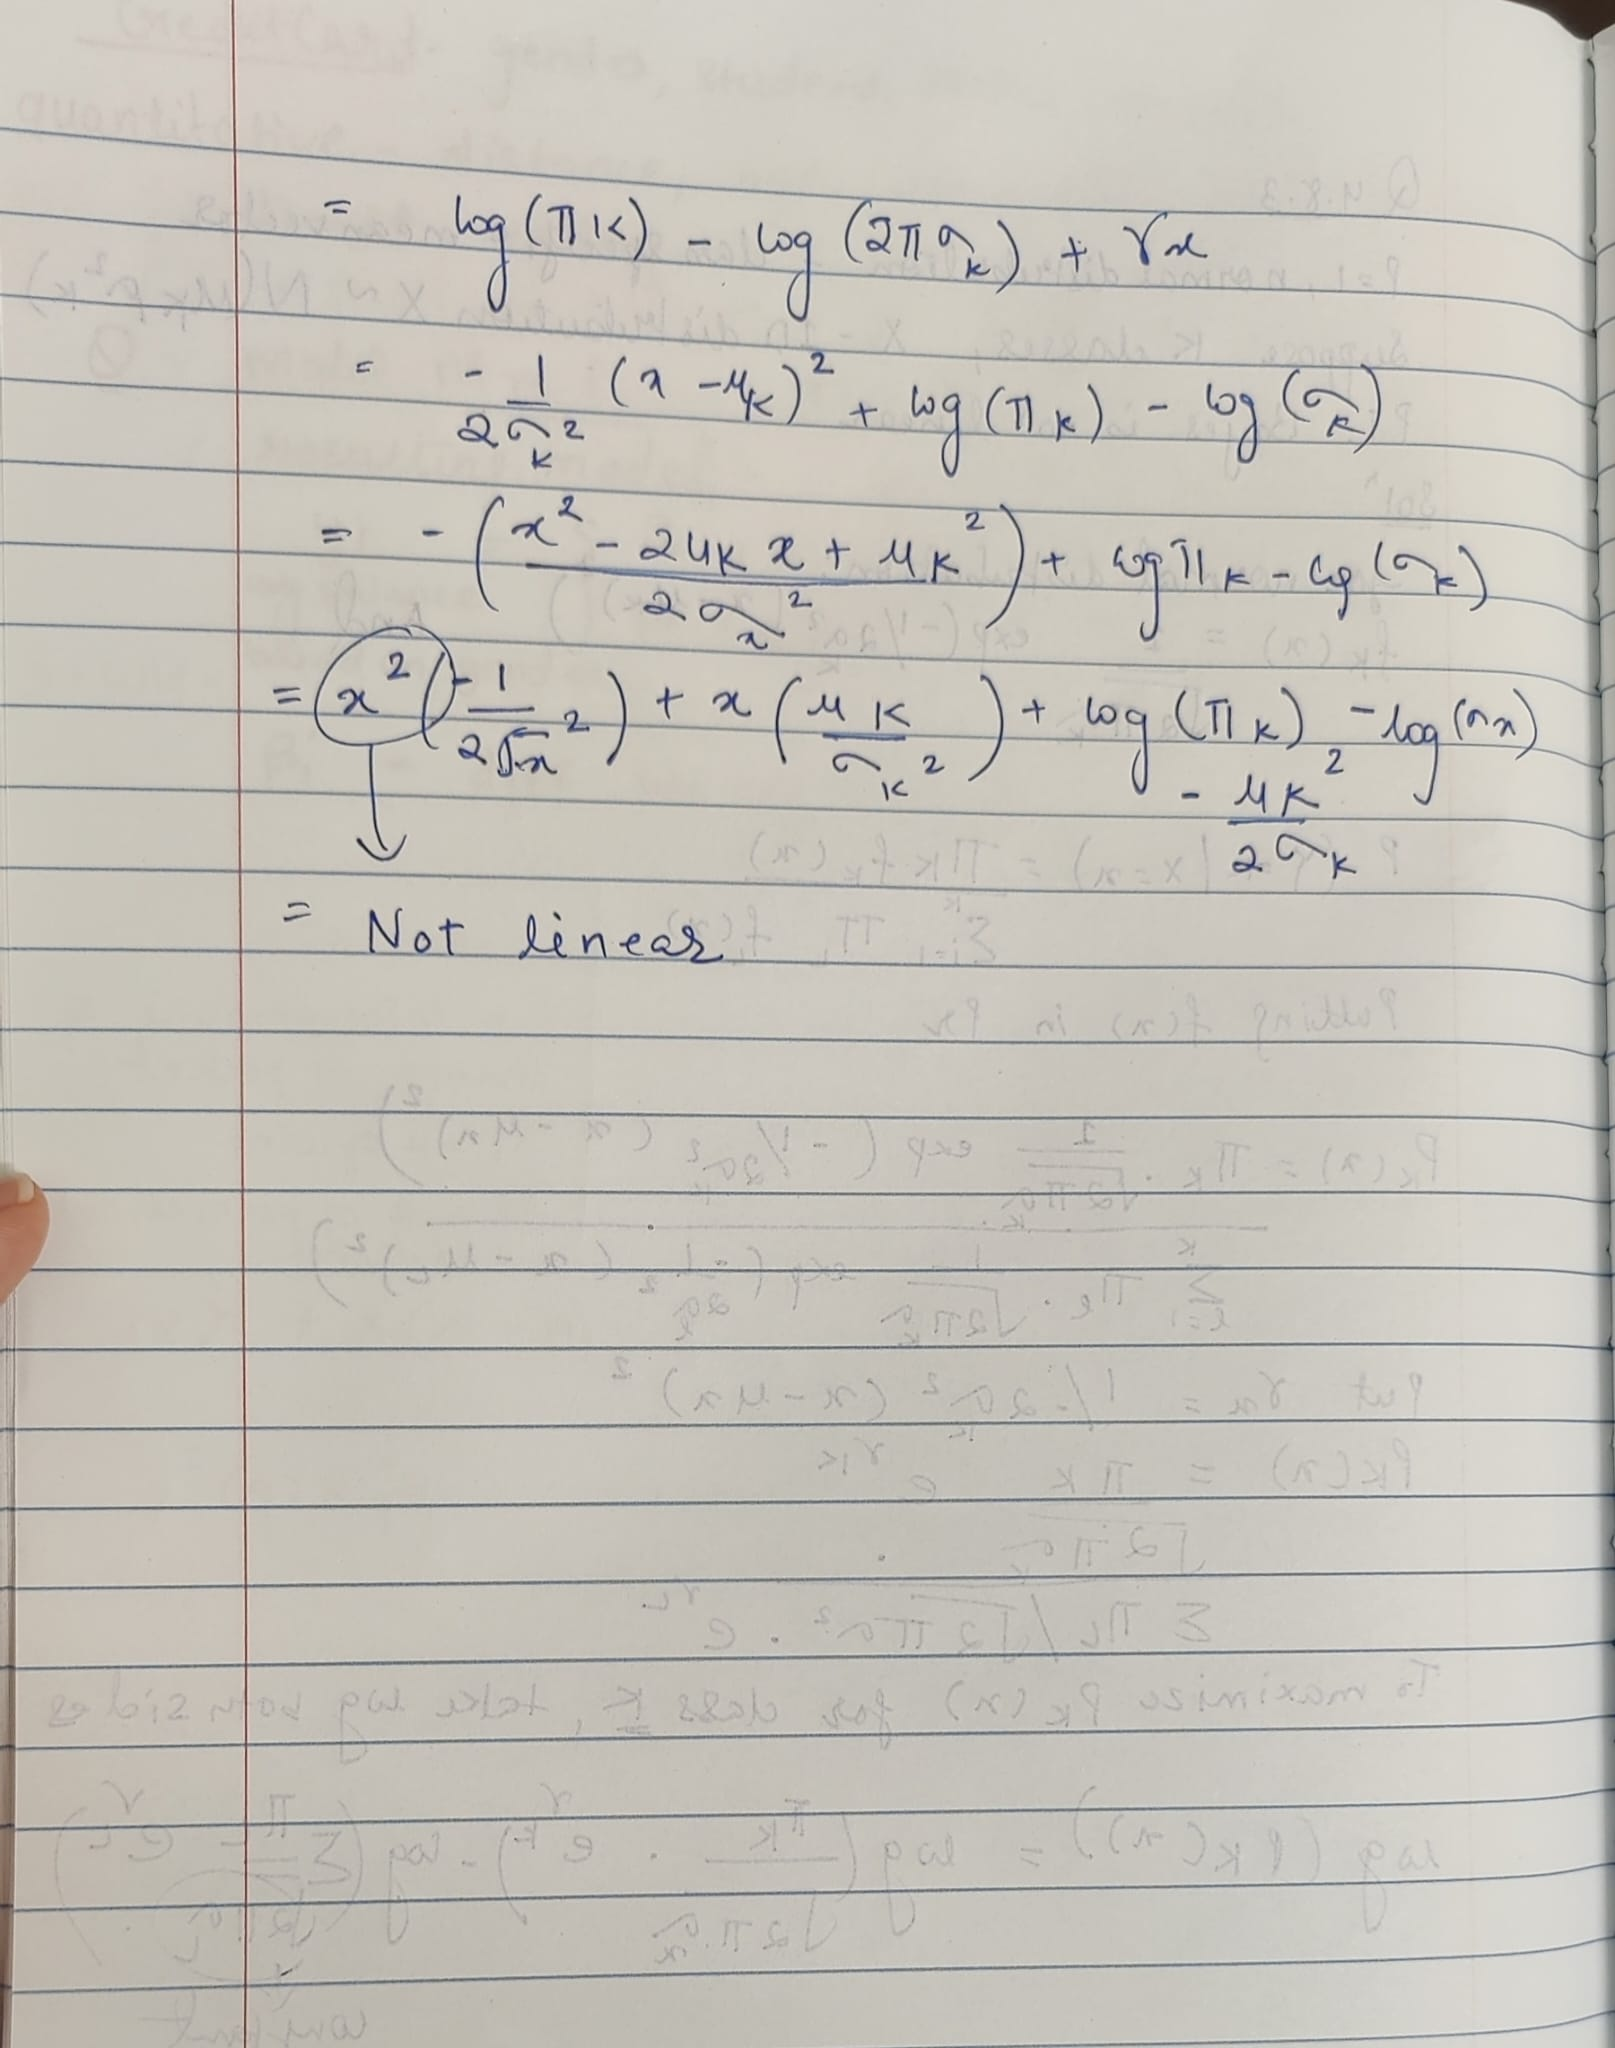

## 4. ISLR 4.8.7

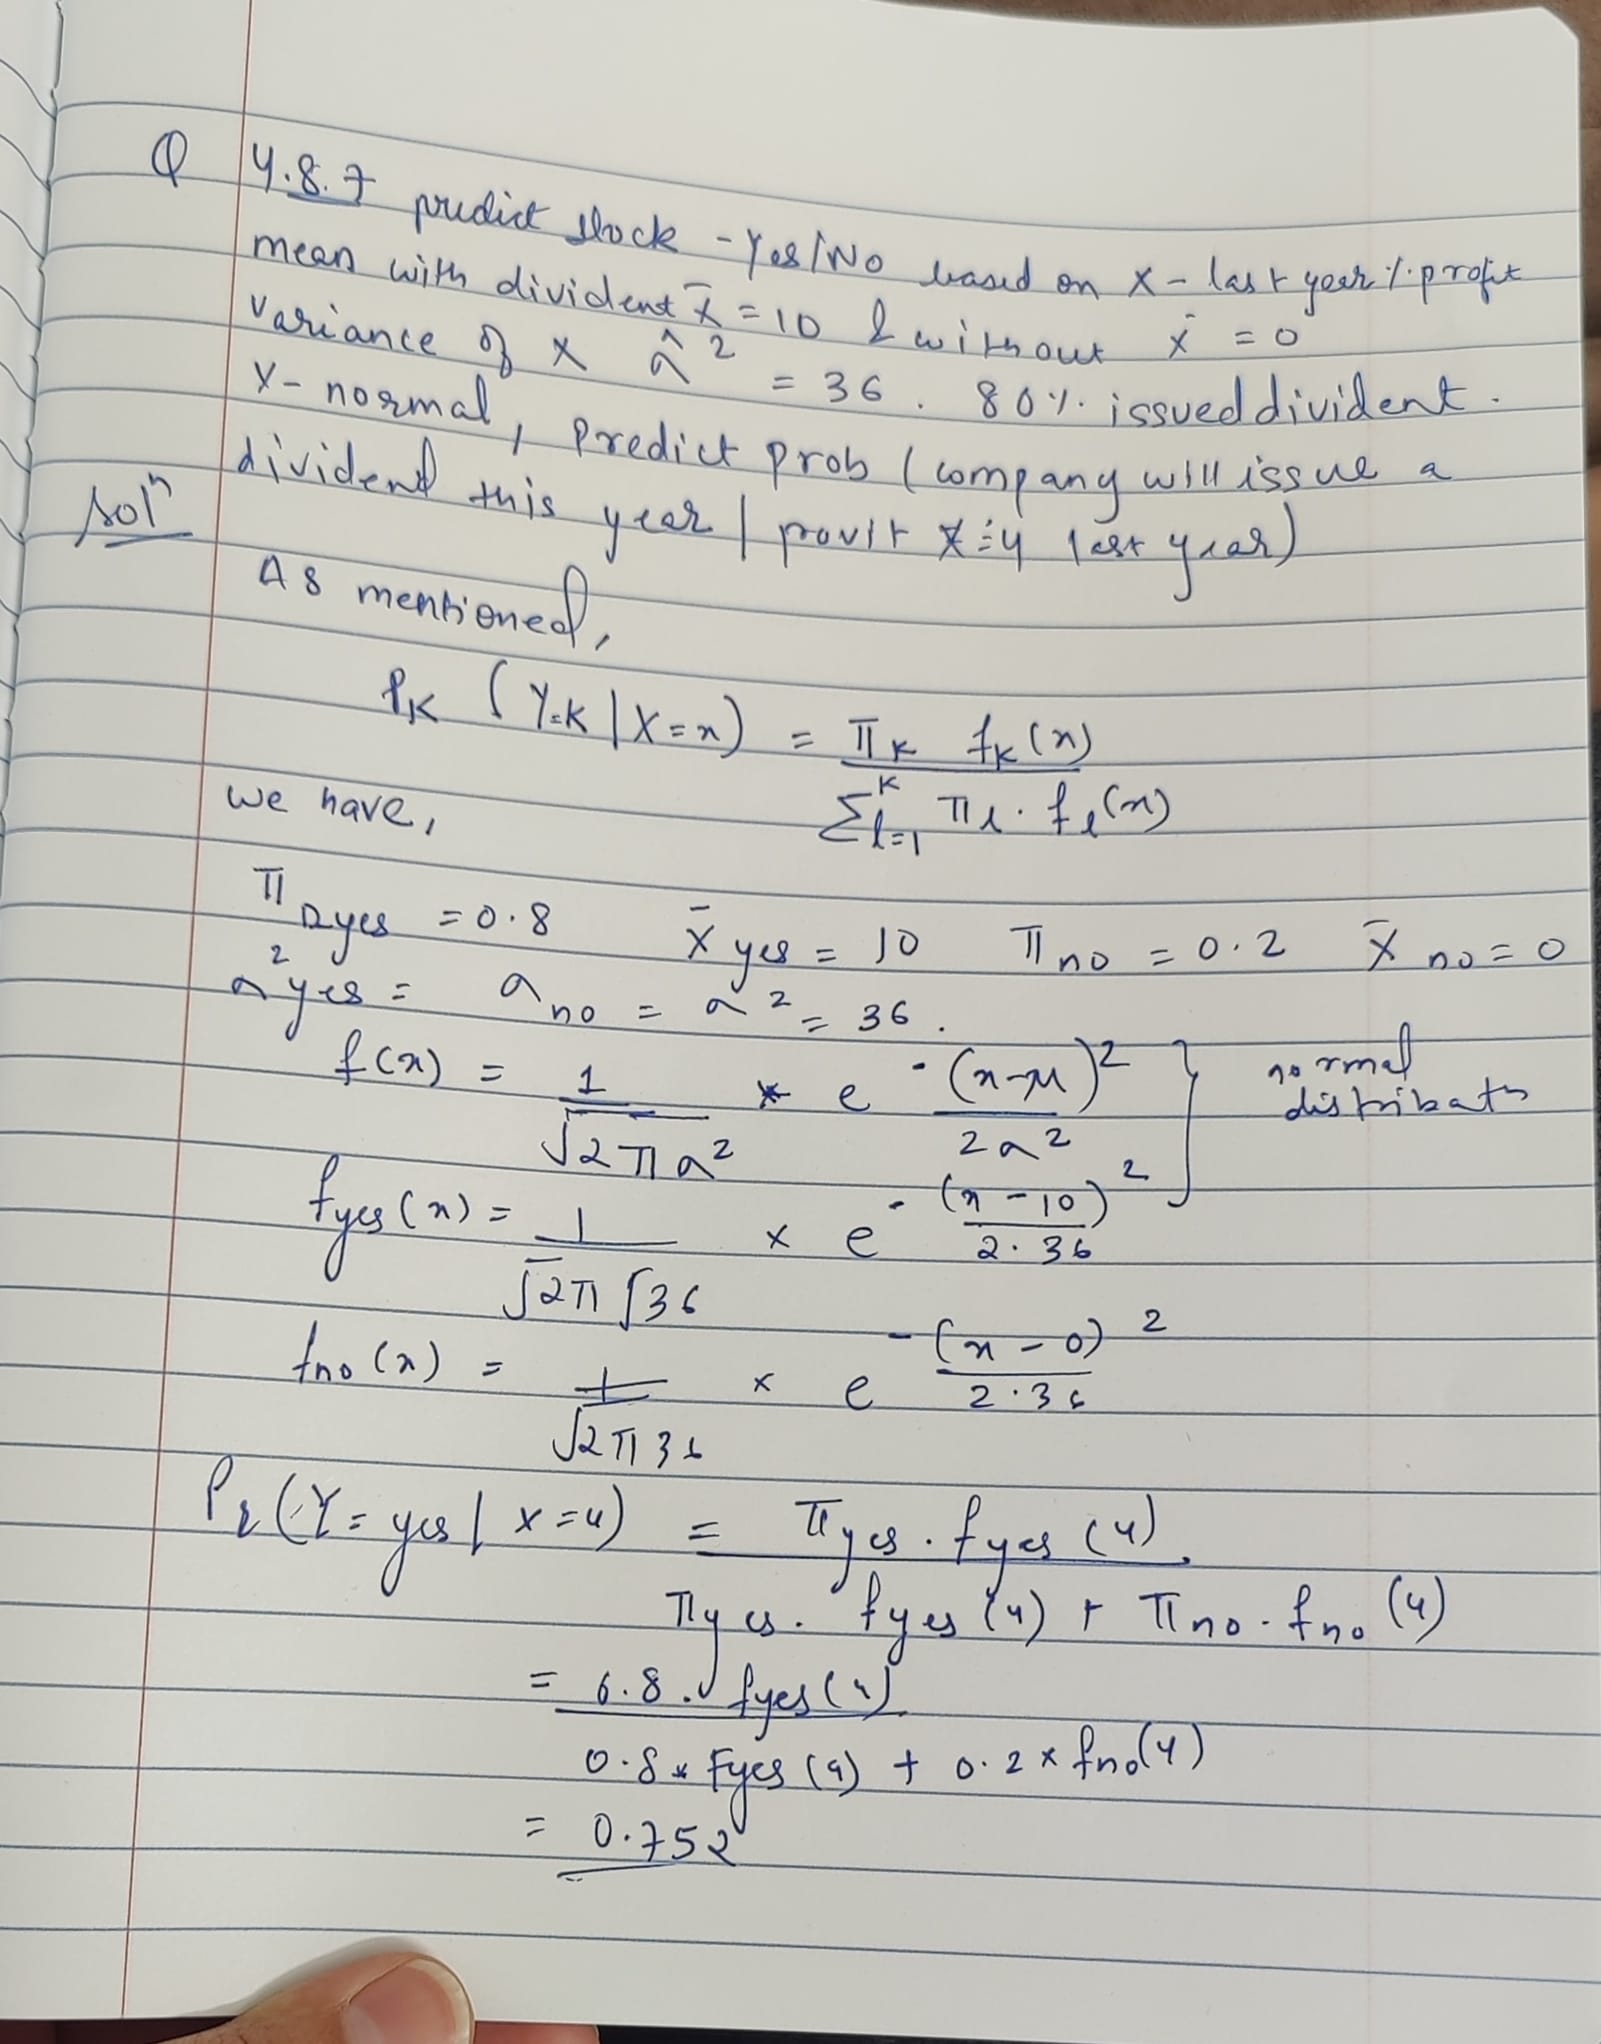